In [208]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori,association_rules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [209]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
# Suprimir advertencias
warnings.filterwarnings("ignore")

In [3]:
# Mapeo de nombres de días en inglés a español
dias_en_espanol = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

In [264]:
df = pd.read_excel("datos.xlsx")

df = df[df["VENDEDOR"] != "GGUERRERO"]

df["FECHA"] = df['FECHA EMISIÓN'].dt.date
df["Año"] = df['FECHA EMISIÓN'].dt.year
df["Mes"] = df['FECHA EMISIÓN'].dt.month
df["Dia"] = df['FECHA EMISIÓN'].dt.day
df["Hora"] = df['FECHA EMISIÓN'].dt.hour
df["Minuto"] = df['FECHA EMISIÓN'].dt.minute
df["DiaNombre"] = df['FECHA EMISIÓN'].dt.day_name().map(dias_en_espanol)
df.head()


,ID,CODIGO,ITEM,CANTIDAD,MONTO SIN IVA,MONTO FINAL (INC IVA),SUCURSAL,VENDEDOR,FACTURA,FECHA EMISIÓN,RUTA,FECHA,Año,Mes,Dia,Hora,Minuto,DiaNombre
0,SER000002,RMOVISTAR,RECARGA DE MOVISTAR,1,0.893,1.000,CUENCA - ESTADIO,SPINOS,001-032-000187013,2023-07-01 08:07:15.468,EN RUTA,2023-07-01,2023,7,1,8,7,Sábado
1,ITE009441,10158188,FUNDA CAMISETA PLASTICA PEQUENA YALOBOX,1,0.000,0.000,CUENCA - ESTADIO,SPINOS,001-032-000187014,2023-07-01 08:08:28.310,EN RUTA,2023-07-01,2023,7,1,8,8,Sábado
2,ITE000063,040000422068,CHOCOLATE MILKYWAY 52.2GR,1,1.339,1.500,CUENCA - ESTADIO,SPINOS,001-032-000187014,2023-07-01 08:08:28.310,EN RUTA,2023-07-01,2023,7,1,8,8,Sábado
3,ITE006257,759494998422,ENERGIZANTE V220 ORIGINAL 330ML,1,0.446,0.500,CUENCA - ESTADIO,SPINOS,001-032-000187015,2023-07-01 08:08:39.808,EN RUTA,2023-07-01,2023,7,1,8,8,Sábado
4,ITE009441,10158188,FUNDA CAMISETA PLASTICA PEQUENA YALOBOX,1,0.000,0.000,CUENCA - ESTADIO,SPINOS,001-032-000187016,2023-07-01 08:21:53.010,EN RUTA,2023-07-01,2023,7,1,8,21,Sábado


In [270]:
df['Hora'].unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  7,
        0], dtype=int32)

In [265]:
print(df['MONTO SIN IVA'].sum())
df.describe()

13225.251599999998


,CANTIDAD,MONTO SIN IVA,MONTO FINAL (INC IVA),FECHA EMISIÓN,Año,Mes,Dia,Hora,Minuto
count,11927.000,11927.000,11927.000,11927,11927.000,11927.000,11927.000,11927.000,11927.000
mean,1.258,1.109,1.229,2023-07-16 07:44:37.427672576,2023.000,7.000,15.668,15.200,29.653
min,1.000,0.000,0.000,2023-07-01 08:07:15.468000,2023.000,7.000,1.000,0.000,0.000
25%,1.000,0.312,0.350,2023-07-08 08:58:01.344499968,2023.000,7.000,8.000,12.000,14.000
50%,1.000,0.536,0.600,2023-07-15 18:05:07.687000064,2023.000,7.000,15.000,15.000,30.000
75%,1.000,1.000,1.100,2023-07-23 14:19:48.047500032,2023.000,7.000,23.000,18.000,45.000
max,16.000,52.938,59.290,2023-07-31 20:14:44.667000,2023.000,7.000,31.000,23.000,59.000
std,0.903,1.959,2.186,NaN,0.000,0.000,8.857,4.228,17.440


# Vista General

In [266]:
df_agrupado_item = df.groupby(['VENDEDOR','ITEM','DiaNombre','Hora'])[['CANTIDAD','MONTO SIN IVA','MONTO FINAL (INC IVA)']].sum().reset_index().sort_values('CANTIDAD', ascending=False)
print(df_agrupado_item.shape)
# Trunca los nombres de los ítems si son demasiado largos
df_agrupado_item['ITEMv2'] = [item[:15] + '...' if len(item) > 15 else item for item in df_agrupado_item['ITEM']]

df_agrupado_item.head()

(9061, 7)


,VENDEDOR,ITEM,DiaNombre,Hora,CANTIDAD,MONTO SIN IVA,MONTO FINAL (INC IVA),ITEMv2
5648,KRAMON,TARJETA DE PARQUEO SERT EMOV,Viernes,13,35,35.000,35.000,TARJETA DE PARQ...
7735,SPINOS,FUNDA CAMISETA PLASTICA MEDIANA YALOBOX,Jueves,21,25,0.003,0.003,FUNDA CAMISETA ...
8838,SPINOS,TARJETA DE PARQUEO SERT EMOV,Sábado,10,21,21.000,21.000,TARJETA DE PARQ...
5613,KRAMON,TARJETA DE PARQUEO SERT EMOV,Lunes,9,21,21.000,21.000,TARJETA DE PARQ...
7736,SPINOS,FUNDA CAMISETA PLASTICA MEDIANA YALOBOX,Jueves,22,21,0.002,0.002,FUNDA CAMISETA ...


# Grafico 1:   
Dias y horas que mas se vende por tipo de vendedor
 

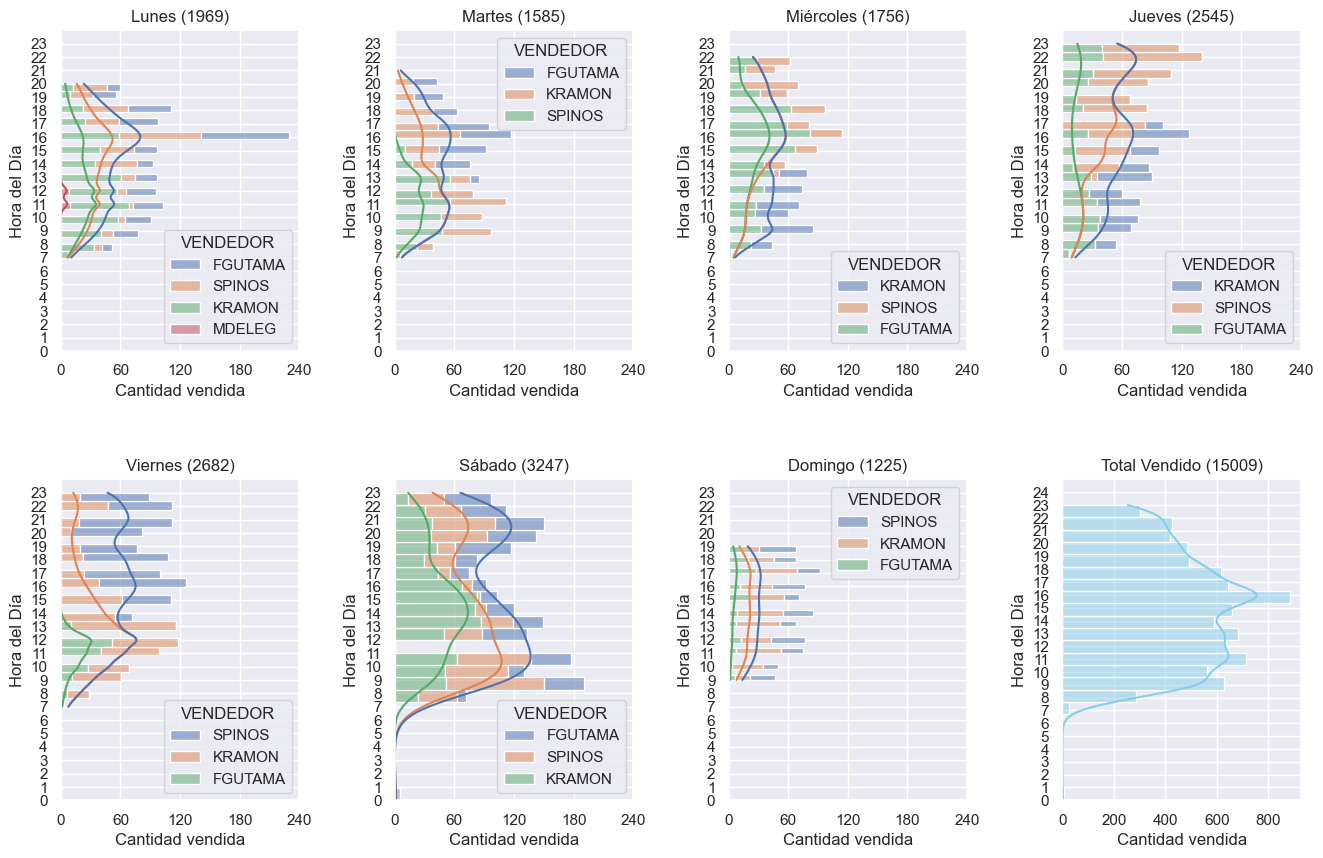

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear una lista de días de la semana en el orden deseado
orden_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

# Utilizar pd.Categorical para ordenar la columna 'DiaNombre' en el orden deseado
df_agrupado_item['DiaNombre'] = pd.Categorical(df_agrupado_item['DiaNombre'], categories=orden_semana, ordered=True)

# Ordenar el DataFrame según la columna 'DiaNombre'
df_agrupado_item = df_agrupado_item.sort_values(by='DiaNombre')

# Crear la figura y las subparcelas en una cuadrícula de 2 filas y 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

# Configurar los gráficos para cada día de la semana
for i, dia in enumerate(orden_semana):
    fila = i // 4  # Calcular la fila actual (0 o 1)
    columna = i % 4  # Calcular la columna actual (0, 1, 2 o 3)
    
    ax = axes[fila, columna]  # Seleccionar la subparcela en la fila y columna actual
    
    datos_dia = df_agrupado_item[df_agrupado_item['DiaNombre'] == dia]
    sns.histplot(data=datos_dia, y="Hora", bins=25, ax=ax, color="skyblue", kde=True, hue='VENDEDOR',multiple="stack")
    
    # Título y etiquetas de los ejes
    ax.set_title(f"{dia} ({datos_dia['CANTIDAD'].sum()})")
    ax.set_xlabel("Cantidad vendida")
    ax.set_ylabel("Hora del Día")
    
    # Establecer los límites y ticks del eje y
    ax.set(ylim=(0, 24), xlim=(0, 240))
    ax.set_yticks(range(24))
    ax.set_xticks(range(0, 241, 60))
    
    # Mostrar líneas de cuadrícula en el eje y
    ax.yaxis.grid(True)

# Agregar un último gráfico para la cantidad total vendida por hora
ax_total = axes[1, 3]
sns.histplot(data=df_agrupado_item, y="Hora", bins=24, ax=ax_total, color="skyblue", kde=True)
ax_total.set_title(f"Total Vendido ({df_agrupado_item['CANTIDAD'].sum()})")
ax_total.set_xlabel("Cantidad vendida")
ax_total.set_ylabel("Hora del Día")
ax_total.set(ylim=(0, 25))
ax_total.set_yticks(range(25))
ax_total.yaxis.grid(True)

# Ajustar el diseño de las subparcelas
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Espacio entre las subparcelas

# Mostrar los gráficos
plt.show()


# Grafico 2:   
Dias y horas que mas se vende por tipo de vendedor y Monto Acumulado
 

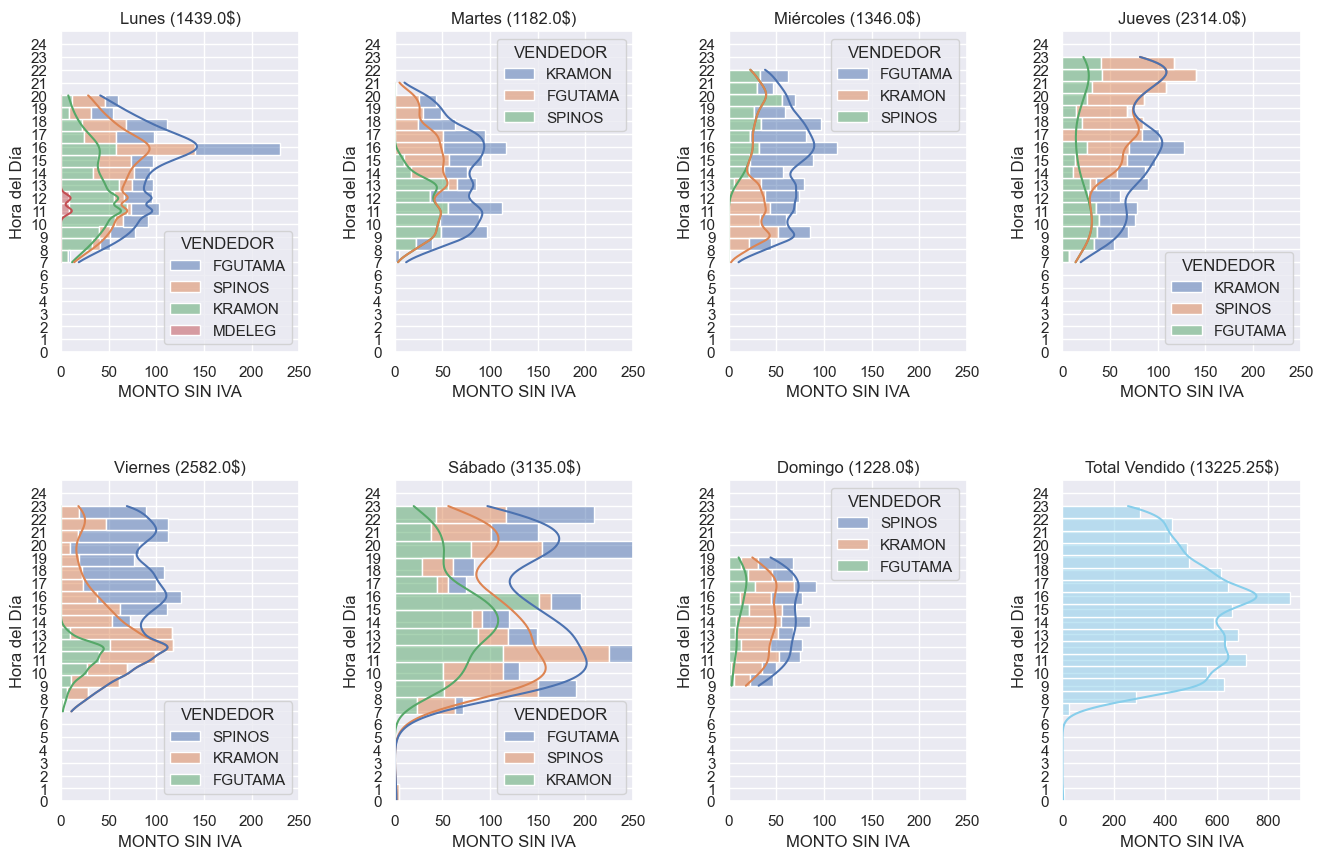

In [280]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear una lista de días de la semana en el orden deseado
orden_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

# Utilizar pd.Categorical para ordenar la columna 'DiaNombre' en el orden deseado
df_agrupado_item['DiaNombre'] = pd.Categorical(df_agrupado_item['DiaNombre'], categories=orden_semana, ordered=True)

# Ordenar el DataFrame según la columna 'DiaNombre'
df_agrupado_item = df_agrupado_item.sort_values(by='DiaNombre')

# Crear la figura y las subparcelas en una cuadrícula de 2 filas y 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(16, 10))

# Configurar los gráficos para cada día de la semana
for i, dia in enumerate(orden_semana):
    fila = i // 4  # Calcular la fila actual (0 o 1)
    columna = i % 4  # Calcular la columna actual (0, 1, 2 o 3)
    
    ax = axes[fila, columna]  # Seleccionar la subparcela en la fila y columna actual
    
    datos_dia = df_agrupado_item[df_agrupado_item['DiaNombre'] == dia]
    sns.histplot(data=datos_dia, y="Hora", bins=len(datos_dia['Hora'].unique()), ax=ax, color="skyblue", kde=True, hue='VENDEDOR', multiple="stack")
    
    # Título y etiquetas de los ejes
    ax.set_title(f"{dia} ({np.round(datos_dia['MONTO SIN IVA'].sum())}$)")
    ax.set_xlabel("MONTO SIN IVA")
    ax.set_ylabel("Hora del Día")
    # ax.legend(loc="lower right")
    
    # Establecer los límites y ticks del eje y
    ax.set(ylim=(0, 25), xlim=(0, 250))
    ax.set_yticks(range(25))
    ax.set_xticks(range(0, 251, 50))
    
    # Mostrar líneas de cuadrícula en el eje y
    ax.yaxis.grid(True)

# Agregar un último gráfico para la MONTO SIN IVA total vendida por hora
ax_total = axes[1, 3]
sns.histplot(data=df_agrupado_item, y="Hora", bins=24, ax=ax_total, color="skyblue", kde=True)
ax_total.set_title(f"Total Vendido ({np.round(df_agrupado_item['MONTO SIN IVA'].sum(),2)}$)")
ax_total.set_xlabel("MONTO SIN IVA")
ax_total.set_ylabel("Hora del Día")
ax_total.set(ylim=(0, 25))
ax_total.set_yticks(range(25))
ax_total.yaxis.grid(True)

# Ajustar el diseño de las subparcelas
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Espacio entre las subparcelas

# Mostrar los gráficos
plt.show()


# Grafico 3:
Multiple Graficos

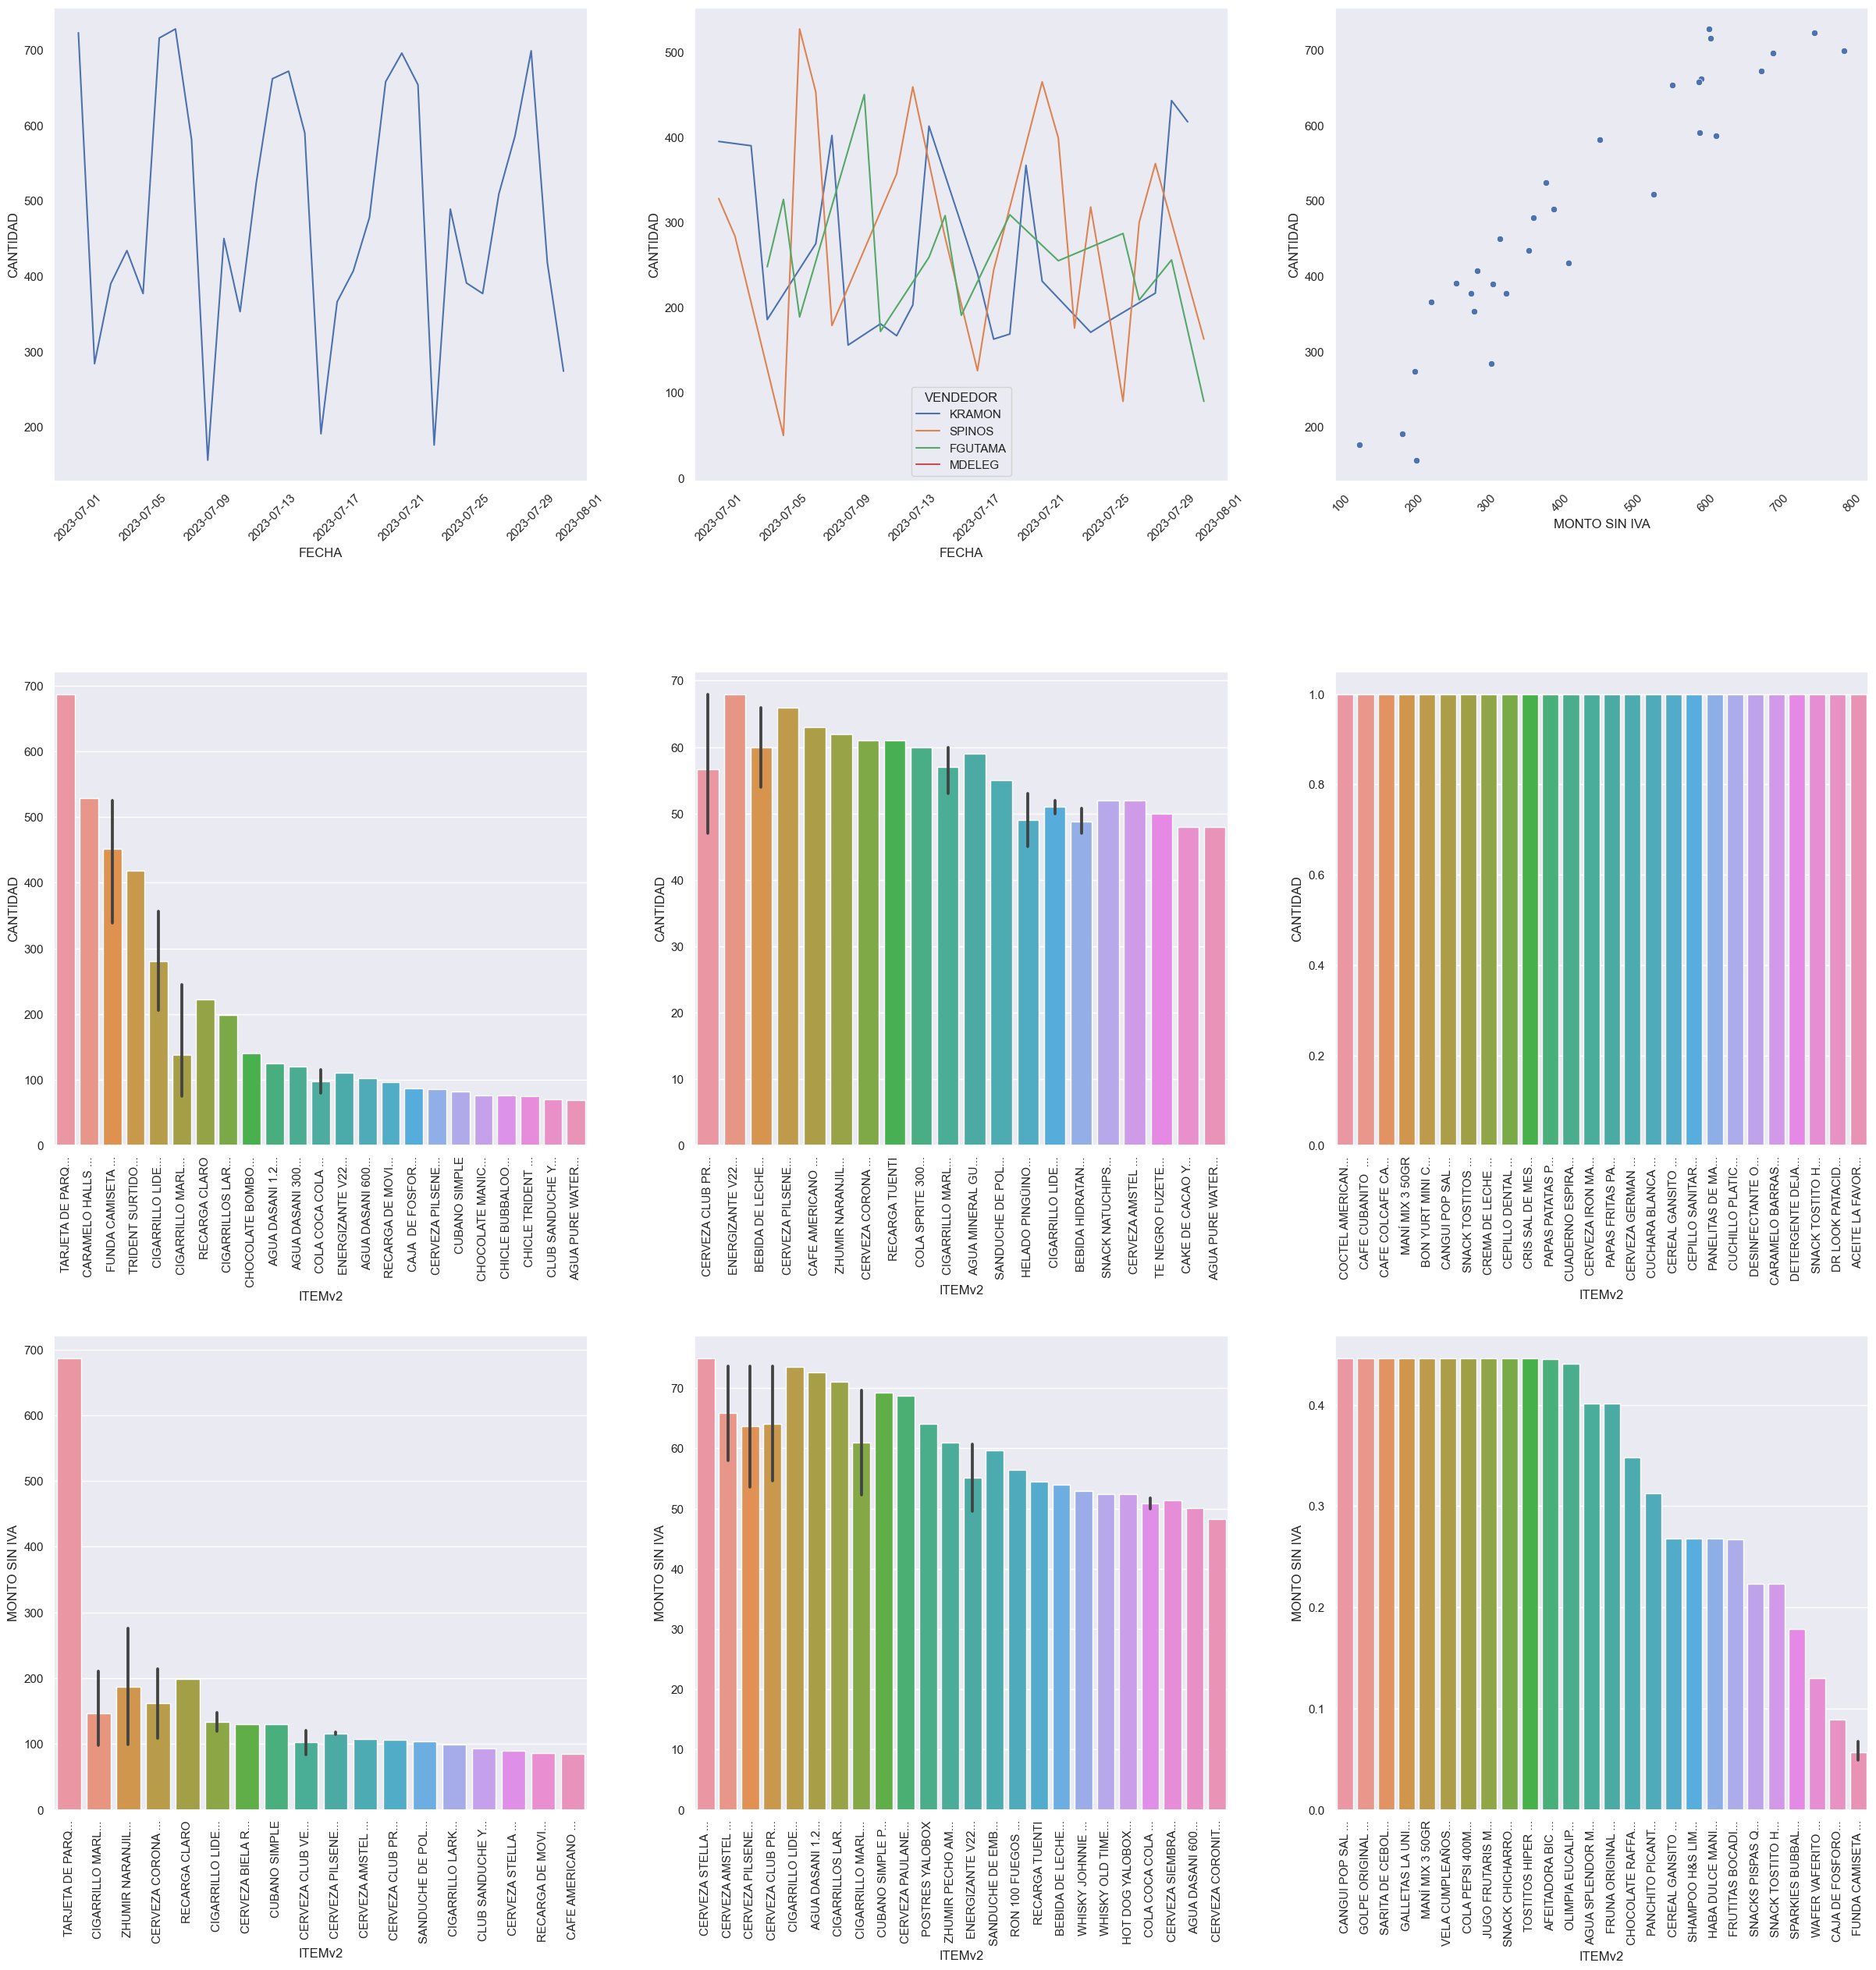

In [346]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columnas numéricas válidas: 'CANTIDAD', 'MONTO SIN IVA', 'MONTO FINAL (INC IVA)'

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(30, 30))

# Grafico 1:
df_agrupado_fecha = df.groupby(['FECHA'])[['CANTIDAD','MONTO SIN IVA','MONTO FINAL (INC IVA)']].sum().reset_index().sort_values('FECHA', ascending=True)

sns.set_theme(style="darkgrid")
sns.lineplot(data=df_agrupado_fecha, x="FECHA", y="CANTIDAD",ax=ax1)
ax1.grid()

# Rotar las etiquetas del eje x en el primer gráfico
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Grafico 2:
df_agrupado_fecha_Vendedor = df.groupby(['FECHA','VENDEDOR'])[['CANTIDAD','MONTO SIN IVA','MONTO FINAL (INC IVA)']].sum().reset_index().sort_values('FECHA', ascending=True)
sns.set_theme(style="darkgrid")
sns.lineplot(data=df_agrupado_fecha_Vendedor, x="FECHA", y="CANTIDAD", hue='VENDEDOR',ax=ax2)
ax2.grid()
# Rotar las etiquetas del eje x en el segundo gráfico
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


#Grafico 3:
sns.scatterplot(data=df_agrupado_fecha, x="MONTO SIN IVA", y="CANTIDAD", ax=ax3)
ax3.grid()
# Rotar las etiquetas del eje x en el segundo gráfico
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


#Grafico 4:
df_agrupado_itemV2 = df.groupby(['ITEM'])[['CANTIDAD','MONTO SIN IVA','MONTO FINAL (INC IVA)']].sum().reset_index().sort_values('CANTIDAD', ascending=False)
# Trunca los nombres de los ítems si son demasiado largos
df_agrupado_itemV2['ITEMv2'] = [item[:15] + '...' if len(item) > 15 else item for item in df_agrupado_itemV2['ITEM']]

sns.barplot(data=df_agrupado_itemV2.iloc[:30], x='ITEMv2', y='CANTIDAD',ax=ax4 )
# Rotar las etiquetas del eje x en el primer gráfico
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=90)

#Grafico 5:
# Trunca los nombres de los ítems si son demasiado largos
sns.barplot(data=df_agrupado_itemV2.iloc[30:60], x='ITEMv2', y='CANTIDAD',ax=ax5 )
# Rotar las etiquetas del eje x en el primer gráfico
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=90)

# grafico 6:
sns.barplot(data=df_agrupado_itemV2.iloc[-30:], x='ITEMv2', y='CANTIDAD',ax=ax6 )
# Rotar las etiquetas del eje x en el primer gráfico
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=90)



#Grafico 7:
df_agrupado_itemV2 = df.groupby(['ITEM'])[['CANTIDAD','MONTO SIN IVA','MONTO FINAL (INC IVA)']].sum().reset_index().sort_values('MONTO SIN IVA', ascending=False)
# Trunca los nombres de los ítems si son demasiado largos
df_agrupado_itemV2['ITEMv2'] = [item[:15] + '...' if len(item) > 15 else item for item in df_agrupado_itemV2['ITEM']]

sns.barplot(data=df_agrupado_itemV2.iloc[:30], x='ITEMv2', y='MONTO SIN IVA',ax=ax7 )
# Rotar las etiquetas del eje x en el primer gráfico
ax7.set_xticklabels(ax7.get_xticklabels(), rotation=90)

#Grafico 8:
# Trunca los nombres de los ítems si son demasiado largos
sns.barplot(data=df_agrupado_itemV2.iloc[30:60], x='ITEMv2', y='MONTO SIN IVA',ax=ax8)
# Rotar las etiquetas del eje x en el primer gráfico
ax8.set_xticklabels(ax8.get_xticklabels(), rotation=90)



#Grafico 9:
sns.barplot(data=df_agrupado_itemV2.iloc[-30:], x='ITEMv2', y='MONTO SIN IVA',ax=ax9 )
# Rotar las etiquetas del eje x en el primer gráfico
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=90)



# Ajustar el espaciado vertical entre los gráficos
plt.subplots_adjust(hspace=0.4)
plt.show()


# CORRELACIONES:

In [445]:
df[df['FACTURA'] == '001-032-000187016']

,ID,CODIGO,ITEM,CANTIDAD,MONTO SIN IVA,MONTO FINAL (INC IVA),SUCURSAL,VENDEDOR,FACTURA,FECHA EMISIÓN,RUTA,FECHA,Año,Mes,Dia,Hora,Minuto,DiaNombre
4,ITE009441,10158188,FUNDA CAMISETA PLASTICA PEQUENA YALOBOX,1,0.000,0.000,CUENCA - ESTADIO,SPINOS,001-032-000187016,2023-07-01 08:21:53.010,EN RUTA,2023-07-01,2023,7,1,8,21,Sábado
5,ITE006712,10158187,FUNDA CAMISETA PLASTICA MEDIANA YALOBOX,1,0.000,0.000,CUENCA - ESTADIO,SPINOS,001-032-000187016,2023-07-01 08:21:53.010,EN RUTA,2023-07-01,2023,7,1,8,21,Sábado
6,ITE009843,7861012514083,YOGURT TONI MIX FRUTI BOLITAS FRBO 180G,1,0.850,0.850,CUENCA - ESTADIO,SPINOS,001-032-000187016,2023-07-01 08:21:53.010,EN RUTA,2023-07-01,2023,7,1,8,21,Sábado
7,ITE009827,7861012514076,YOGURT TONI MIX FRUTILLA 180GR,1,0.900,0.900,CUENCA - ESTADIO,SPINOS,001-032-000187016,2023-07-01 08:21:53.010,EN RUTA,2023-07-01,2023,7,1,8,21,Sábado
8,ITE002022,7861012510863,CAFE CAFFE LATO MOCACCINO 250CM3 TETRAPACK,2,1.518,1.700,CUENCA - ESTADIO,SPINOS,001-032-000187016,2023-07-01 08:21:53.010,EN RUTA,2023-07-01,2023,7,1,8,21,Sábado


In [444]:
df_corr= df.groupby(['FACTURA','ITEM'])[['CANTIDAD']].sum().reset_index()
df_corr.sort_values('FACTURA').head(10)

,FACTURA,ITEM,CANTIDAD
0,001-032-000187013,RECARGA DE MOVISTAR,1
1,001-032-000187014,CHOCOLATE MILKYWAY 52.2GR,1
2,001-032-000187014,FUNDA CAMISETA PLASTICA PEQUENA YALOBOX,1
3,001-032-000187015,ENERGIZANTE V220 ORIGINAL 330ML,1
4,001-032-000187016,CAFE CAFFE LATO MOCACCINO 250CM3 TETRAPACK,2
5,001-032-000187016,FUNDA CAMISETA PLASTICA MEDIANA YALOBOX,1
6,001-032-000187016,FUNDA CAMISETA PLASTICA PEQUENA YALOBOX,1
7,001-032-000187016,YOGURT TONI MIX FRUTI BOLITAS FRBO 180G,1
8,001-032-000187016,YOGURT TONI MIX FRUTILLA 180GR,1
10,001-032-000187017,TRIDENT SURTIDO POR UNIDAD,1


In [484]:
# Calcula la matriz de correlación
corr_matrix = df_corr.pivot_table(index='FACTURA', columns='ITEM', values='CANTIDAD', fill_value=0).corr()
corr_matrix #[['ACEITE LA FAVORITA ORIGINAL 2 LITROS']].sort_values(by='ACEITE LA FAVORITA ORIGINAL 2 LITROS', ascending=False).iloc[:30]

ITEM                                            ACEITE LA FAVORITA ORIGINAL 2 LITROS  \
ITEM                                                                                   
ACEITE LA FAVORITA ORIGINAL 2 LITROS                                           1.000   
AFEITADORA BIC COMFORT 3 SENSITIVE                                            -0.000   
AGOGO CHICLE ACILIQUIDO MIX 3 SABORES X5U                                     -0.001   
AGOGO FRESA X5U 11.5G                                                         -0.001   
AGUA AROMATICA SABOR MANZANILLA  ILE 25U                                      -0.000   
...                                                                              ...   
ZHUMIR PECHO AMARILLO 700ML                                                   -0.000   
ZHUMIR PINK 700CM                                                             -0.000   
ZHUMIR PINK WATERMELON FLAVOR CON BRILLO 700ML                                -0.000   
ZHUMIR SECO SUAVE  350ML                                                      -0.000   
ZHUMIR SECO SUAVE DURAZNO 350ML                                               -0.000   

ITEM                                            AFEITADORA BIC COMFORT 3 SENSITIVE  \
ITEM                                                                                 
ACEITE LA FAVORITA ORIGINAL 2 LITROS                                        -0.000   
AFEITADORA BIC COMFORT 3 SENSITIVE                                           1.000   
AGOGO CHICLE ACILIQUIDO MIX 3 SABORES X5U                                   -0.001   
AGOGO FRESA X5U 11.5G                                                       -0.001   
AGUA AROMATICA SABOR MANZANILLA  ILE 25U                                    -0.000   
...                                                                            ...   
ZHUMIR PECHO AMARILLO 700ML                                                 -0.000   
ZHUMIR PINK 700CM                                                           -0.000   
ZHUMIR PINK WATERMELON FLAVOR CON BRILLO 700ML                              -0.000   
ZHUMIR SECO SUAVE  350ML                                                    -0.000   
ZHUMIR SECO SUAVE DURAZNO 350ML                                             -0.000   

ITEM                                            AGOGO CHICLE ACILIQUIDO MIX 3 SABORES X5U  \
ITEM                                                                                        
ACEITE LA FAVORITA ORIGINAL 2 LITROS                                               -0.001   
AFEITADORA BIC COMFORT 3 SENSITIVE                                                 -0.001   
AGOGO CHICLE ACILIQUIDO MIX 3 SABORES X5U                                           1.000   
AGOGO FRESA X5U 11.5G                                                               0.020   
AGUA AROMATICA SABOR MANZANILLA  ILE 25U                                           -0.001   
...                                                                                   ...   
ZHUMIR PECHO AMARILLO 700ML                                                        -0.001   
ZHUMIR PINK 700CM                                                                  -0.001   
ZHUMIR PINK WATERMELON FLAVOR CON BRILLO 700ML                                     -0.001   
ZHUMIR SECO SUAVE  350ML                                                           -0.001   
ZHUMIR SECO SUAVE DURAZNO 350ML                                                    -0.001   

ITEM                                            AGOGO FRESA X5U 11.5G  \
ITEM                                                                    
ACEITE LA FAVORITA ORIGINAL 2 LITROS                           -0.001   
AFEITADORA BIC COMFORT 3 SENSITIVE                             -0.001   
AGOGO CHICLE ACILIQUIDO MIX 3 SABORES X5U                       0.020   
AGOGO FRESA X5U 11.5G                                           1.000   
AGUA AROMATICA SABOR MANZANILLA  ILE 25U                       -0.001   
...            

In [466]:
# Filtra las correlaciones
high_corr = corr_matrix[(corr_matrix > 0.5) & (corr_matrix < 1.0)]
low_corr = corr_matrix[(corr_matrix < -0.5) & (corr_matrix > -1.0)]

# Si deseas obtener solo los valores de correlación mayores a +0.5 y menores a -0.5
high_corr_values = high_corr.stack()
low_corr_values = low_corr.stack()



In [485]:

# Convierte los valores filtrados en DataFrames
df_low_corr = pd.DataFrame({'High_Correlation': low_corr_values}).reset_index(level=0)
df_low_corr = df_low_corr.rename(columns={'ITEM': 'ITEM_N2'}).reset_index()
df_low_corr = df_low_corr.rename(columns={'ITEM': 'ITEM_N1'}).sort_values('ITEM_N1')


df_high_corr = pd.DataFrame({'High_Correlation': high_corr_values}).reset_index(level=0)
df_high_corr = df_high_corr.rename(columns={'ITEM': 'ITEM_N2'}).reset_index()
df_high_corr = df_high_corr.rename(columns={'ITEM': 'ITEM_N1'}).sort_values('ITEM_N1')


In [486]:
df_high_corr.tail()

,ITEM_N1,ITEM_N2,High_Correlation
324,VINO TINTO LAMBRUSCO SUAVE SEMISECO 750ML,SNACK TOSTACHOS PICANTES 100GR,0.707
302,YOGURT FITNESS SABILA 180G,ROSQUITAS INTEGRALES SUPAN 200G,0.707
219,YOGURT GRIEGO TONI FRUTILLA 150GR,JAMON LA ITALIANA SANDUCHERO TIPO 2 85GR,0.571
285,YOGURT GRIEGO TONI FRUTILLA 150GR,QUESO CREMA TONI 250GR,0.756
244,ZHUMIR SECO SUAVE DURAZNO 350ML,LICOR ZHUMIR CANUTO EDICION DE CAÑA 700ML,0.756


In [490]:
df_high_corr.to_excel("Correlacion de productos.xlsx")

# Modelo de recomendación

In [493]:
itemsCorrelacionados = df_high_corr['ITEM_N1'].unique()
itemsCorrelacionados.shape

(124,)

In [496]:
dfModelo = df[df['ITEM'].isin(itemsCorrelacionados)]
print(df.shape)
print(dfModelo.shape)
dfModelo


(11927, 18)
(934, 18)


,ID,CODIGO,ITEM,CANTIDAD,MONTO SIN IVA,MONTO FINAL (INC IVA),SUCURSAL,VENDEDOR,FACTURA,FECHA EMISIÓN,RUTA,FECHA,Año,Mes,Dia,Hora,Minuto,DiaNombre
39,ITE001936,7861009942639,ROSQUITAS INTEGRALES SUPAN 200G,1,1.900,1.900,CUENCA - ESTADIO,SPINOS,001-032-000187026,2023-07-01 09:06:18.231,EN RUTA,2023-07-01,2023,7,1,9,6,Sábado
71,ITE010059,7861091146366,GALLETAS RICAS NESTLE 58GR,1,0.402,0.450,CUENCA - ESTADIO,SPINOS,001-032-000187044,2023-07-01 09:33:57.985,EN RUTA,2023-07-01,2023,7,1,9,33,Sábado
82,ITE002314,7861024624725,AGUA DASANI 1.2LT,4,2.322,2.600,CUENCA - ESTADIO,SPINOS,001-032-000187048,2023-07-01 09:52:57.937,EN RUTA,2023-07-01,2023,7,1,9,52,Sábado
83,ITE006095,7861024624091,AGUA DASANI 300ML,13,3.483,3.901,CUENCA - ESTADIO,SPINOS,001-032-000187048,2023-07-01 09:52:57.937,EN RUTA,2023-07-01,2023,7,1,9,52,Sábado
84,ITE002262,7861024605861,BEBIDA HIDRATANTE POWERADE FRUTOS TROPICALES,7,3.750,4.200,CUENCA - ESTADIO,SPINOS,001-032-000187048,2023-07-01 09:52:57.937,EN RUTA,2023-07-01,2023,7,1,9,52,Sábado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11890,ITE002314,7861024624725,AGUA DASANI 1.2LT,1,0.580,0.650,CUENCA - ESTADIO,FGUTAMA,001-032-000193319,2023-07-31 16:44:58.752,EN RUTA,2023-07-31,2023,7,31,16,44,Lunes
11913,ITE002312,7861024622905,BEBIDA HIDRATANTE POWERADE MANZANA CLEAR 500ML,1,0.536,0.600,CUENCA - ESTADIO,FGUTAMA,001-032-000193334,2023-07-31 17:42:31.979,EN RUTA,2023-07-31,2023,7,31,17,42,Lunes
11935,ITE003398,ARROZLIBRA,ARROZ CAMELIA FLOR 1LBS,2,1.200,1.200,CUENCA - ESTADIO,FGUTAMA,001-032-000193345,2023-07-31 19:15:27.919,EN RUTA,2023-07-31,2023,7,31,19,15,Lunes
11937,ITE010563,7861153909465,CHORIZO PAISA BOTON LA ITALIANA 135GR,1,1.250,1.250,CUENCA - ESTADIO,FGUTAMA,001-032-000193347,2023-07-31 19:57:58.924,EN RUTA,2023-07-31,2023,7,31,19,57,Lunes
